In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)


with open('YALE_ABDOMINAL_PAIN.npy', 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f).reshape(-1)
    X_test = np.load(f)
    y_test = np.load(f).reshape(-1)

classes = ['0', '1']
classes_name = ['Discharged', 'Admitted']

X_all = np.concatenate((X_train,X_test))
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

y_labels = np.concatenate((y_train,y_test))

n = X_train.shape[0]
    
print(X_train.shape, y_train.shape, X_train.dtype)
print(X_test.shape, y_test.shape, X_test.dtype)
print(X_all.shape, y_all.shape, X_all.dtype)
print(np.sum(y_labels==0), np.sum(y_labels==1))

c1 = 'k'
c2 = 'r'
DPI = 400
    
%matplotlib inline

%load_ext autoreload
%autoreload 2

(43452, 1016) (43452,) float64
(10863, 1016) (10863,) float64
(54315, 1016) (54315,) float64
34833 19482


In [2]:
import numba
from numba import prange

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val



In [3]:
def fig_plot(X,y,filename):
    plt.figure(figsize=[6,5])
    plt.scatter(X[:,0], X[:,1], c=y, s=0.1, cmap='Spectral')
    
    plt.xticks([],[])
    plt.yticks([],[])
    
    plt.savefig('Shortness/'+filename, bbox_inches='tight', dpi=DPI)

    return

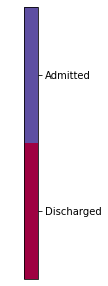

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=[6,5])

fraction = 1  # .05

classes = ['Discharged',
          'Admitted']#,
          #'Discharged (Test)',
          #'Admitted (Test)']

values = np.arange(len(classes))

norm = mpl.colors.Normalize(vmin=values[0], vmax=values[-1])
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='Spectral'),
            boundaries=np.arange(len(classes)+1)-0.5,
            ax=ax, fraction=fraction)
cbar.set_ticks(np.arange(len(classes)))
cbar.set_ticklabels(classes)

ax.margins(0,0)

ax.axis('off')
plt.show()

fig.savefig('Abdominal_Figure/yale_abdominal_colorbar.png', bbox_inches='tight', dpi=DPI)

In [5]:
sort_idx,_ = get_first_order_graph(X_all,n_neighbors=X_all.shape[0]-1)

/home/ponir/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Completed  10000  of  54315
Completed  20000  of  54315
Completed  30000  of  54315
Completed  40000  of  54315
Completed  50000  of  54315


In [6]:
sort_idx_tr,_ = get_first_order_graph(X_train,n_neighbors=X_train.shape[0]-1)

Completed  10000  of  43452
Completed  20000  of  43452
Completed  30000  of  43452
Completed  40000  of  43452


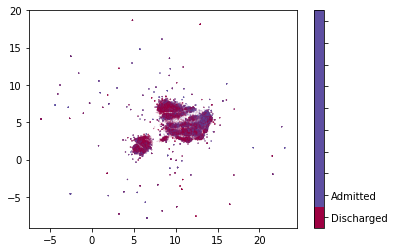

In [41]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.0001,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

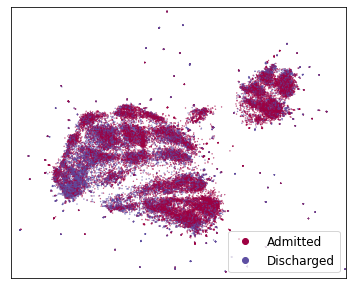

In [42]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))
y_umap_tr_te = np.concatenate((y_train, y_test+2))


plt.figure(figsize=[6,5])

scatter = plt.scatter(-y_umap[:,0], -y_umap[:,1], 
            c=y_train, s=0.1, cmap='Spectral')

plt.xlim([-16,-3])
plt.ylim([-10,2])

plt.xticks([])
plt.yticks([])

lgd = plt.legend(*scatter.legend_elements(),
                    loc="lower right",
                    fontsize=12)
lgd.get_texts()[0].set_text('Admitted') #PA
lgd.get_texts()[1].set_text('Discharged') #AP

plt.savefig('Abdominal_Figure/yale_abd_umap.png', bbox_inches='tight', dpi=DPI)

In [43]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (TRAIN->TEST)
1-NN error:  0.4129614287029366
5-NN error:  0.3619626254257572


In [44]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)



Trustworthiness: UMAP (TRAIN->TEST)
5:  0.8338541500488947
30:  0.8194410410458028
100:  0.8026554362146869
Trustworthiness: UMAP (TRAIN)
5:  0.8422523553872059
30:  0.8216385777116428
100:  0.8055571540573947


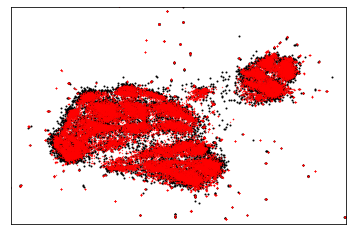

In [46]:
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))
plt.figure()
plt.scatter(-y_umap_test[:,0], -y_umap_test[:,1], c=c1, s=1)
plt.scatter(-y_umap[:,0], -y_umap[:,1], c=c2, s=0.1)


classes_tr = ['train', 'test']

plt.xlim([-16,-3])
plt.ylim([-10,2])

plt.xticks([])
plt.yticks([])

plt.savefig('Abdominal_Figure/yale_abd_umap_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

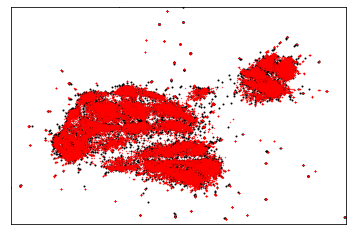

In [47]:
ump.negative_sample_rate=3
y_umap_test = ump.transform(X_test)


plt.figure()
plt.scatter(-y_umap_test[:,0], -y_umap_test[:,1], c=c1, s=1)
plt.scatter(-y_umap[:,0], -y_umap[:,1], c=c2, s=0.1)


classes_tr = ['train', 'test']

plt.xlim([-16,-3])
plt.ylim([-10,2])

plt.xticks([])
plt.yticks([])

plt.savefig('Abdominal_Figure/yale_abd_umap_repulsioneffect_ns_3.png', bbox_inches='tight', dpi=DPI)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (n_s=3) (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (n_s=3) (TRAIN->TEST)
1-NN error:  0.406609592193685
5-NN error:  0.35551873331492223


In [49]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (n_s=3) (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (n_s=3) (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)



Trustworthiness: UMAP (n_s=3) (TRAIN->TEST)
5:  0.8362279047041402
30:  0.8217059483018515
100:  0.805097767728609
Trustworthiness: UMAP (n_s=3) (TRAIN)
5:  0.8422523553872059
30:  0.8216385777116428
100:  0.8055571540573947


<h1>UMAP ALL</h1>

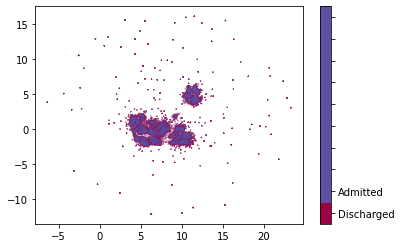

In [15]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.0001,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [16]:
tt_all_5 = my_trustworthiness(t_umap_all, sort_idx, K=5)
tt_all_30 = my_trustworthiness(t_umap_all, sort_idx, K=30)
tt_all_100 = my_trustworthiness(t_umap_all, sort_idx, K=100)

print('Trustworthiness: (UMAP ALL)')
print('5: ', tt_all_5)
print('30: ', tt_all_30)
print('100: ', tt_all_100)

tt_tr_te_5 = my_trustworthiness(t_umap_all[:X_train.shape[0]], sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_all[:X_train.shape[0]], sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_all[:X_train.shape[0]], sort_idx_tr, K=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)



Trustworthiness: (UMAP ALL)
5:  0.8488569176752062
30:  0.8278927897649725
100:  0.808358963316959
Trustworthiness: UMAP (TRAIN)
5:  0.8472009226571653
30:  0.8230448934451384
100:  0.8061438530222554


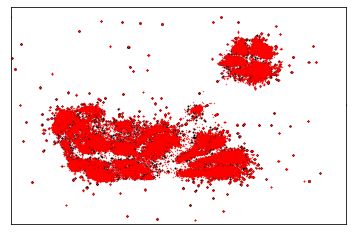

In [17]:
#plt.figure(figsize=(15,15))
plt.figure()
plt.scatter(t_umap_all[X_train.shape[0]:,0], t_umap_all[X_train.shape[0]:,1], c=c1, s=1)
plt.scatter(t_umap_all[:X_train.shape[0],0], t_umap_all[:X_train.shape[0],1], c=c2, s=0.1)


classes_tr = ['train', 'test']

plt.xlim([2,15])
plt.ylim([-5,8])

plt.xticks([])
plt.yticks([])

plt.savefig('Abdominal_Figure/yale_abd_all_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP CE</h1>

In [18]:
from scipy.io import loadmat

d = loadmat('nets_CE/test_data19.mat')
t_ce = d['Y'].copy()
t_ce_test = d['Y_test'].copy()
t_ce_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


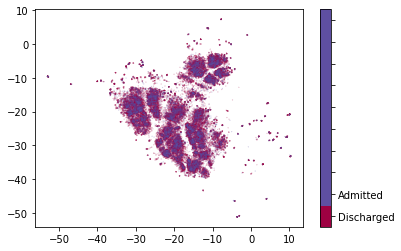

In [19]:
plt.figure()
plt.scatter(t_ce_tr_te[:,0], t_ce_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP CE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_ce, y_train)

y_nene_out = neigh.predict(t_ce_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_ce, y_train)

y_nene_out = neigh.predict(t_ce_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)


Nearest Neighbor: UMAP CE (TRAIN->TEST)
1-NN error:  0.3963914204179324
5-NN error:  0.3467734511645033


In [21]:
tt_ce_5 = my_trustworthiness(t_ce_tr_te, sort_idx, K=5)
tt_ce_30 = my_trustworthiness(t_ce_tr_te, sort_idx, K=30)
tt_ce_100 = my_trustworthiness(t_ce_tr_te, sort_idx, K=100)

print('UMAP CE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_ce_5)
print('30: ', tt_ce_30)
print('100: ', tt_ce_100)

tt_ce_5 = my_trustworthiness(t_ce, sort_idx_tr, K=5)
tt_ce_30 = my_trustworthiness(t_ce, sort_idx_tr, K=30)
tt_ce_100 = my_trustworthiness(t_ce, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_ce_5)
print('30: ', tt_ce_30)
print('100: ', tt_ce_100)


UMAP CE
Trustworthiness: (Train->Test) 
5:  0.8710942947375117
30:  0.8552028637751097
100:  0.8403387218258046
Trustworthiness: (Train) 
5:  0.8770242452341224
30:  0.8557437304897527
100:  0.8399712231508663


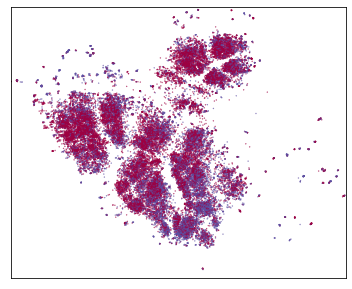

In [22]:
t_ce_tr_te_plot = t_ce_tr_te.copy()
y_umap_tr_te = np.concatenate((y_train, y_test+2))


plt.figure(figsize=[6,5])
plt.scatter(t_ce[:,0], t_ce[:,1], 
            c=y_train, s=0.1, cmap='Spectral')

plt.xlim([-40,8])
plt.ylim([-45,2])

plt.xticks([])
plt.yticks([])

plt.savefig('Abdominal_Figure/yale_abd_ce.png', bbox_inches='tight', dpi=DPI)



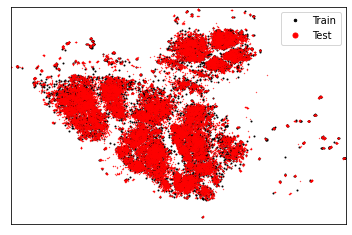

In [23]:
#plt.figure(figsize=(15,15))
from matplotlib.lines import Line2D
plt.figure()
plt.scatter(t_ce_test[:,0], t_ce_test[:,1], c=c1, s=1)
plt.scatter(t_ce[:,0], t_ce[:,1], c=c2, s=0.1)

legend_elements = [Line2D([0], [0], marker='.', markersize=5, lw=0, color=c1, label='Train'),
                   Line2D([0], [0], marker='.', markersize=10, lw=0, color=c2, label='Test')]

plt.legend(handles=legend_elements)

plt.xlim([-40,8])
plt.ylim([-45,2])

plt.xticks([])
plt.yticks([])

plt.savefig('Abdominal_Figure/yale_abd_ce_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP MSE</h1>

In [24]:
from scipy.io import loadmat

d = loadmat('nets_MSE_UMAP/test_data19.mat')
t_mse = d['Y'].copy()
t_mse_test = d['Y_test'].copy()
t_mse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


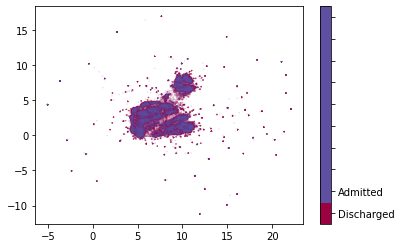

In [25]:
plt.figure()
plt.scatter(t_mse_tr_te[:,0], t_mse_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [26]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP MSE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_mse, y_train)

y_nene_out = neigh.predict(t_mse_test)

err_mse = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_mse)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_mse, y_train)

y_nene_out = neigh.predict(t_mse_test)

err_mse_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_mse_5)


Nearest Neighbor: UMAP MSE (TRAIN->TEST)
1-NN error:  0.4057810917794348
5-NN error:  0.3550584553070054


In [27]:
tt_mse_5 = my_trustworthiness(t_mse_tr_te, sort_idx, K=5)
tt_mse_30 = my_trustworthiness(t_mse_tr_te, sort_idx, K=30)
tt_mse_100 = my_trustworthiness(t_mse_tr_te, sort_idx, K=100)

print('UMAP MSE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_mse_5)
print('30: ', tt_mse_30)
print('100: ', tt_mse_100)

tt_mse_5 = my_trustworthiness(t_mse, sort_idx_tr, K=5)
tt_mse_30 = my_trustworthiness(t_mse, sort_idx_tr, K=30)
tt_mse_100 = my_trustworthiness(t_mse, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_mse_5)
print('30: ', tt_mse_30)
print('100: ', tt_mse_100)

#Epoch 29
#Trustworthiness: (Train->Test) 
#5:  0.8730013667003098
#30:  0.8568916974762673
#100:  0.8404136352261815
#Trustworthiness: (Train) 
#5:  0.8798667745838696
#30:  0.8577890513415286
#100:  0.8404720549608092


UMAP MSE
Trustworthiness: (Train->Test) 
5:  0.8199593484348355
30:  0.809462391173304
100:  0.7940215822114074
Trustworthiness: (Train) 
5:  0.8284522946233892
30:  0.8128019562351363
100:  0.7972737052233161


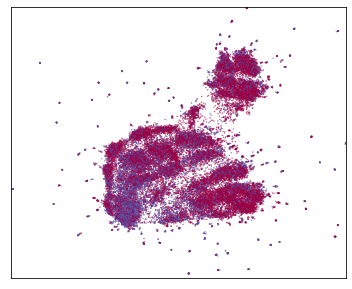

In [28]:
t_ce_tr_te_plot = t_mse_tr_te.copy()
y_umap_tr_te = np.concatenate((y_train, y_test+2))


plt.figure(figsize=[6,5])
plt.scatter(t_mse[:,0], t_mse[:,1], 
            c=y_train, s=0.1, cmap='Spectral')

plt.xlim([0,15])
plt.ylim([-3,11])

plt.xticks([])
plt.yticks([])

plt.savefig('Abdominal_Figure/yale_abd_mse.png', bbox_inches='tight', dpi=DPI)

#Create the Colorbar

#cbar = plt.colorbar() #boundaries=np.arange(11)-0.5

<h1>UMAP CEMSE</h1>

In [29]:
from scipy.io import loadmat

d = loadmat('nets_MSE_CE_UMAP/test_data19.mat')
t_cemse = d['Y'].copy()
t_cemse_test = d['Y_test'].copy()
t_cemse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


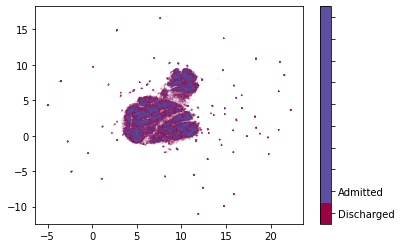

In [30]:
plt.figure()
plt.scatter(t_cemse_tr_te[:,0], t_cemse_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP CEMSE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_cemse, y_train)

y_nene_out = neigh.predict(t_cemse_test)

err_cemse = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_cemse)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_cemse, y_train)

y_nene_out = neigh.predict(t_cemse_test)

err_cemse_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_cemse_5)


Nearest Neighbor: UMAP CEMSE (TRAIN->TEST)
1-NN error:  0.39786431004326617
5-NN error:  0.352112676056338


In [32]:
tt_cemse_5 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=5)
tt_cemse_30 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=30)
tt_cemse_100 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=100)

print('UMAP CEMSE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_cemse_5)
print('30: ', tt_cemse_30)
print('100: ', tt_cemse_100)

tt_cemse_5 = my_trustworthiness(t_cemse, sort_idx_tr, K=5)
tt_cemse_30 = my_trustworthiness(t_cemse, sort_idx_tr, K=30)
tt_cemse_100 = my_trustworthiness(t_cemse, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_cemse_5)
print('30: ', tt_cemse_30)
print('100: ', tt_cemse_100)


UMAP CEMSE
Trustworthiness: (Train->Test) 
5:  0.8349530900117001
30:  0.8288842425458273
100:  0.8138595463917127
Trustworthiness: (Train) 
5:  0.8387672301984955
30:  0.8289690101484822
100:  0.81386503262388


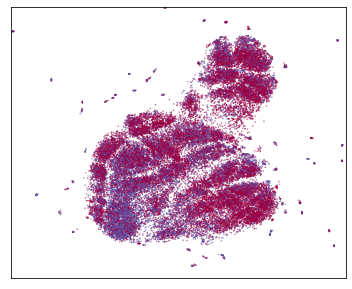

In [33]:
t_cemse_tr_te_plot = t_cemse_tr_te.copy()
y_umap_tr_te = np.concatenate((y_train, y_test+2))


plt.figure(figsize=[6,5])
#plt.scatter(t_cemse_tr_te_plot[:,0], t_cemse_tr_te_plot[:,1], 
#            c=y_umap_tr_te, s=0.1, cmap='Spectral')

plt.scatter(t_cemse[:,0], t_cemse[:,1], 
            c=y_train, s=0.1, cmap='Spectral')

#plt.scatter(t_cemse_test[:,0], t_cemse_test[:,1], 
#            c=y_test, s=0.1, cmap='cool')



plt.xlim([0,15])
plt.ylim([-3,11])

plt.xticks([])
plt.yticks([])


plt.savefig('Abdominal_Figure/yale_abd_cemse.png', bbox_inches='tight', dpi=DPI)

